In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import *
import numpy as np
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo
import time
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, isnan, col, regexp_replace, length
from pyspark.sql.types import *

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
spark = SparkSession.builder.appName("example").getOrCreate()


file_path = 'gdrive/My Drive/BigData/Final/Top2000CompaniesGlobally.csv'
data = spark.read.format("csv")\
        .option("header","true")\
        .option("inferSchema","true")\
        .load(file_path)
data.count()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


1924

In [3]:
data.show()

+-----------+--------------------+----------------+------------------+-----------------+-----------------------+---------------+-------------+----------+----------+
|Global Rank|             Company|Sales ($billion)|Profits ($billion)|Assets ($billion)|Market Value ($billion)|        Country|    Continent|  Latitude| Longitude|
+-----------+--------------------+----------------+------------------+-----------------+-----------------------+---------------+-------------+----------+----------+
|          1|                ICBC|           134.8|              37.8|           2813.5|                  237.3|          China|         Asia|  35.86166|104.195397|
|          2|China Constructio...|           113.1|              30.6|           2241.0|                  202.0|          China|         Asia|  35.86166|104.195397|
|          3|      JPMorgan Chase|           108.2|              21.3|           2359.1|                  191.4|            USA|North America|  37.09024|-95.712891|
|         

In [4]:
data.printSchema()

root
 |-- Global Rank: integer (nullable = true)
 |-- Company: string (nullable = true)
 |-- Sales ($billion): double (nullable = true)
 |-- Profits ($billion): double (nullable = true)
 |-- Assets ($billion): double (nullable = true)
 |-- Market Value ($billion): double (nullable = true)
 |-- Country: string (nullable = true)
 |-- Continent: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [5]:
data.describe().show()

+-------+-----------------+--------------------+------------------+------------------+-----------------+-----------------------+---------+-------------+------------------+------------------+
|summary|      Global Rank|             Company|  Sales ($billion)|Profits ($billion)|Assets ($billion)|Market Value ($billion)|  Country|    Continent|          Latitude|         Longitude|
+-------+-----------------+--------------------+------------------+------------------+-----------------+-----------------------+---------+-------------+------------------+------------------+
|  count|             1924|                1924|              1924|              1924|             1924|                   1924|     1924|         1924|              1924|              1924|
|   mean|997.2328482328483|                NULL|19.265904365904273|1.2260395010395047|79.50779625779606|     19.558160083160104|     NULL|         NULL|34.618746549376155|15.455664304573906|
| stddev|575.5027807871161|                NU

In [6]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+-----------+-------+----------------+------------------+-----------------+-----------------------+-------+---------+--------+---------+
|Global Rank|Company|Sales ($billion)|Profits ($billion)|Assets ($billion)|Market Value ($billion)|Country|Continent|Latitude|Longitude|
+-----------+-------+----------------+------------------+-----------------+-----------------------+-------+---------+--------+---------+
|          0|      0|               0|                 0|                0|                      0|      0|        0|       0|        0|
+-----------+-------+----------------+------------------+-----------------+-----------------------+-------+---------+--------+---------+



In [7]:
data.createOrReplaceTempView("data")

In [8]:
df = spark.sql("SELECT `Sales ($billion)` as Sale,`Market Value ($billion)` as MarketValue FROM data")
df.show(5)

+-----+-----------+
| Sale|MarketValue|
+-----+-----------+
|134.8|      237.3|
|113.1|      202.0|
|108.2|      191.4|
|147.4|      243.7|
|420.7|      400.4|
+-----+-----------+
only showing top 5 rows



In [9]:
df.select('Sale').distinct().orderBy('Sales ($billion)').show(10, False)

+----+
|Sale|
+----+
|0.0 |
|0.2 |
|0.3 |
|0.4 |
|0.5 |
|0.6 |
|0.7 |
|0.8 |
|0.9 |
|1.0 |
+----+
only showing top 10 rows



In [10]:
df.select('MarketValue').distinct().orderBy('Market Value ($billion)').show(10, False)

+-----------+
|MarketValue|
+-----------+
|0.0        |
|0.1        |
|0.2        |
|0.3        |
|0.4        |
|0.5        |
|0.6        |
|0.7        |
|0.8        |
|0.9        |
+-----------+
only showing top 10 rows



In [11]:
sales = df.rdd.map(lambda p: (p.Sale)).collect()

In [12]:
sale_df = DataFrame({'Sale':sales})

In [13]:
data_min = 0.0
data_max = 469.2
data_count = 1924
data_mean = 19.26
data_stddev = 34.68

# Calculate interquartile range (IQR)
q75, q25 = np.percentile(sale_df['Sale'], [75 ,25])
iqr = q75 - q25

# Calculate bin width using Freedman-Diaconis rule
bin_width = 2 * iqr / (data_count ** (1/3))

# Calculate the number of bins using the data range and bin width
num_bins = int((data_max - data_min) / bin_width)
print(num_bins)

203


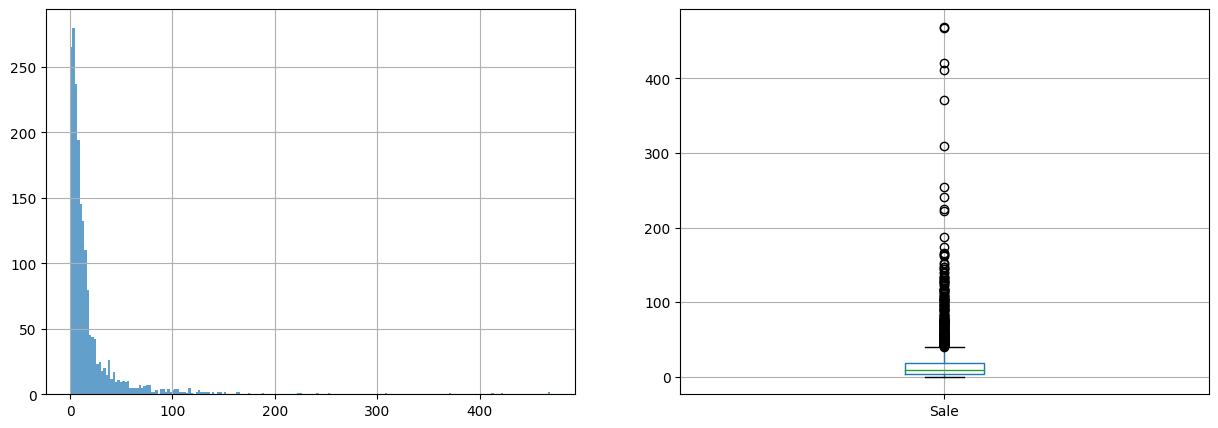

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sale_df['Sale'].hist(bins=203,ax=axes[0], alpha=0.7)
sale_df['Sale'].to_frame().boxplot(ax=axes[1], vert=True);

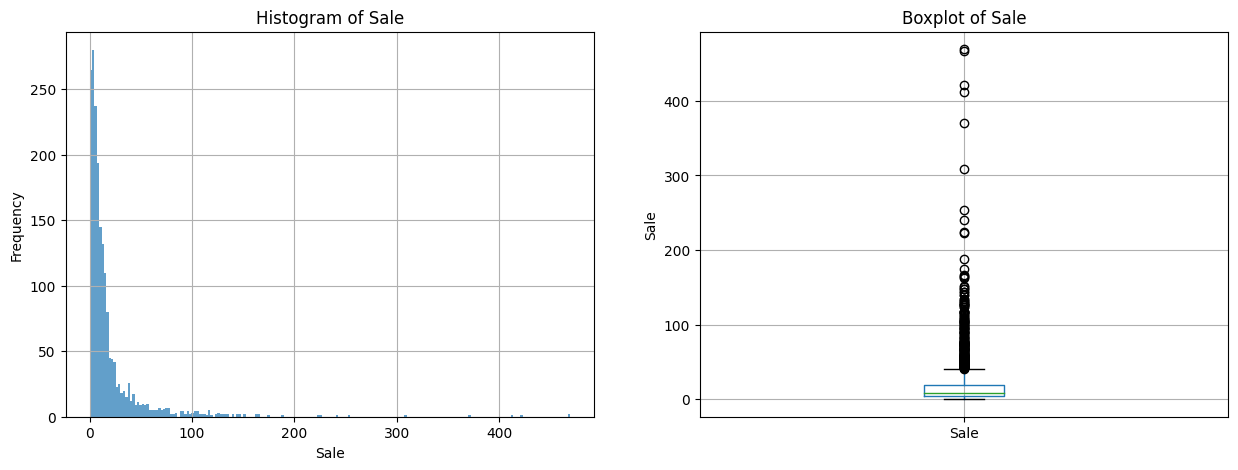

In [15]:
# Create a subplot with 1 row and 2 columns, setting the figure size to (15, 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the histogram of the 'Sale' column in the first subplot (axes[0])
sale_df['Sale'].hist(bins=203, ax=axes[0], alpha=0.7)

# Plot the boxplot of the 'Sale' column in the second subplot (axes[1])
sale_df[['Sale']].boxplot(ax=axes[1], vert=True)

# Set labels for the subplots
axes[0].set_title('Histogram of Sale')
axes[0].set_xlabel('Sale')
axes[0].set_ylabel('Frequency')

axes[1].set_title('Boxplot of Sale')
axes[1].set_ylabel('Sale')

# Display the plot
plt.show()

In [16]:
market_value = df.rdd.map(lambda p: (p.MarketValue)).collect()

In [17]:
market_value_df = DataFrame({'Market_value': market_value})

In [18]:
data_min = 0.0
data_max = 416.6
data_count = 1924
data_mean = 19.558
data_stddev = 32.957

# Calculate interquartile range (IQR)
q75, q25 = np.percentile(market_value_df['Market_value'], [75 ,25])
iqr = q75 - q25

# Calculate bin width using Freedman-Diaconis rule
bin_width = 2 * iqr / (data_count ** (1/3))

# Calculate the number of bins using the data range and bin width
num_bins = int((data_max - data_min) / bin_width)
print(num_bins)

186


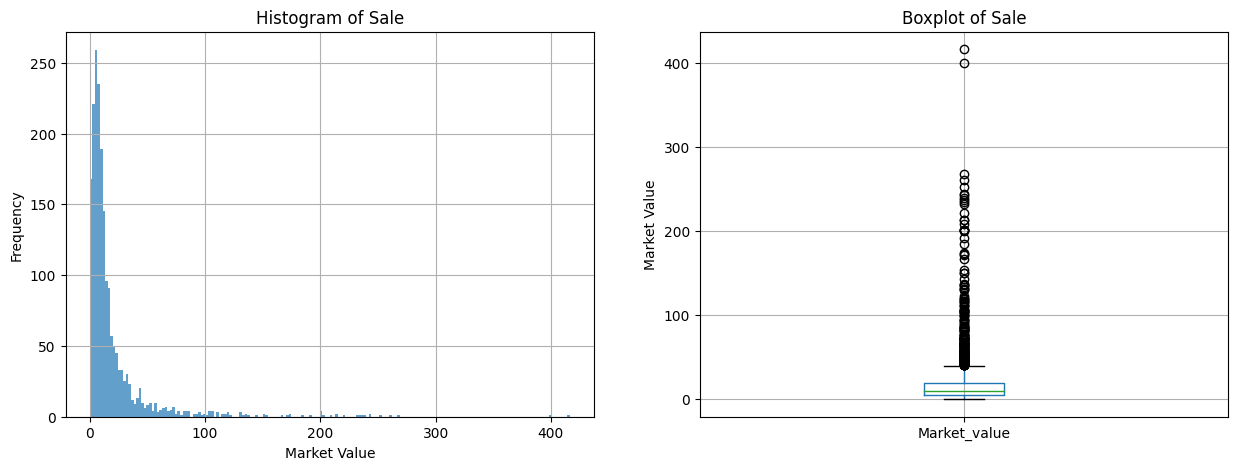

In [19]:
# Create a subplot with 1 row and 2 columns, setting the figure size to (15, 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the histogram of the 'Sale' column in the first subplot (axes[0])
market_value_df['Market_value'].hist(bins=186, ax=axes[0], alpha=0.7)

# Plot the boxplot of the 'Sale' column in the second subplot (axes[1])
market_value_df[['Market_value']].boxplot(ax=axes[1], vert=True)

# Set labels for the subplots
axes[0].set_title('Histogram of Sale')
axes[0].set_xlabel('Market Value')
axes[0].set_ylabel('Frequency')

axes[1].set_title('Boxplot of Sale')
axes[1].set_ylabel('Market Value')

# Display the plot
plt.show()

### Phân tích dữ liệu

In [20]:
x = df.rdd.map(lambda p: (p.Sale)).collect()
y = df.rdd.map(lambda p: (p.MarketValue)).collect()

In [21]:
data_df = DataFrame({'Sale':x, 'MarketValue':y})

### Chuẩn bị dữ liệu

In [22]:
df.show()

+-----+-----------+
| Sale|MarketValue|
+-----+-----------+
|134.8|      237.3|
|113.1|      202.0|
|108.2|      191.4|
|147.4|      243.7|
|420.7|      400.4|
|104.9|      201.3|
|467.2|      213.1|
|103.0|      150.8|
|308.9|      261.2|
|162.5|      252.8|
| 98.1|      131.7|
| 91.2|      201.3|
|222.6|      232.5|
|254.0|       94.4|
|469.2|      242.5|
|164.7|      416.6|
|144.0|      111.4|
|370.9|      130.4|
| 90.7|      143.6|
|144.1|      120.7|
+-----+-----------+
only showing top 20 rows



In [23]:
df.createOrReplaceTempView("split_data")
X = spark.sql("SELECT DOUBLE(Sale) FROM split_data")
Y = spark.sql("SELECT DOUBLE(MarketValue) FROM split_data")

In [24]:
X.show(20)

+-----+
| Sale|
+-----+
|134.8|
|113.1|
|108.2|
|147.4|
|420.7|
|104.9|
|467.2|
|103.0|
|308.9|
|162.5|
| 98.1|
| 91.2|
|222.6|
|254.0|
|469.2|
|164.7|
|144.0|
|370.9|
| 90.7|
|144.1|
+-----+
only showing top 20 rows



In [25]:
Y.show(20)

+-----------+
|MarketValue|
+-----------+
|      237.3|
|      202.0|
|      191.4|
|      243.7|
|      400.4|
|      201.3|
|      213.1|
|      150.8|
|      261.2|
|      252.8|
|      131.7|
|      201.3|
|      232.5|
|       94.4|
|      242.5|
|      416.6|
|      111.4|
|      130.4|
|      143.6|
|      120.7|
+-----------+
only showing top 20 rows



In [26]:
# Chia dữ liệu theo tỉ lệ train:test 7:3
X_train, X_test = X.randomSplit([0.7, 0.3], seed = 2)
Y_train, Y_test = Y.randomSplit([0.7, 0.3], seed = 2)

In [27]:
X_train.describe().show()

+-------+------------------+
|summary|              Sale|
+-------+------------------+
|  count|              1325|
|   mean|18.790113207547183|
| stddev|34.781117916289176|
|    min|               0.0|
|    max|             469.2|
+-------+------------------+



In [28]:
X_test.describe().show()

+-------+-----------------+
|summary|             Sale|
+-------+-----------------+
|  count|              599|
|   mean|20.31836393989984|
| stddev|34.47352379441042|
|    min|              0.3|
|    max|            467.2|
+-------+-----------------+



In [29]:
Y_train.describe().show()

+-------+------------------+
|summary|       MarketValue|
+-------+------------------+
|  count|              1325|
|   mean|18.900000000000002|
| stddev|  31.9327848651619|
|    min|               0.0|
|    max|             416.6|
+-------+------------------+



In [30]:
Y_test.describe().show()

+-------+-----------------+
|summary|      MarketValue|
+-------+-----------------+
|  count|              599|
|   mean|21.01402337228713|
| stddev|35.10057318333682|
|    min|              0.2|
|    max|            400.4|
+-------+-----------------+



# Thuật toán Linear Regression (Hướng làm 1)


In [37]:
# rdd_X_train = X_train.rdd
rdd_X_train = X_train.rdd.map(list)
rdd_Y_train = Y_train.rdd.map(list)

In [38]:
# rdd_X_test = X_test.rdd
rdd_X_test = X_test.rdd.map(list)
rdd_Y_test = Y_test.rdd.map(list)

In [42]:
# Kiểm tra giá trị X train và Y train
rdd_X_train.count()
rdd_Y_train.count()

1325

In [43]:
# Tính giá trị trung bình của danh sách số
def mean(data):
  sum=data.reduce(lambda a, b: a + b)
  return sum / data.count()

In [44]:
# Tính mẫu số B1 (Slope)
def deno_slope(data, mean):
  deno_slope = data.map(lambda a: (a - mean) ** 2)
  result = deno_slope.reduce(lambda a, b: a + b)
  return result

In [45]:
# Chuyển rdd_X_train thành danh sách các giá trị
rdd_X_train_1 = rdd_X_train.map(lambda a: a[0])

In [59]:
# Danh sách các giá trị
rdd_X_train_1.take(10)

[0.0, 0.2, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.4, 0.5]

In [47]:
# Giá trị trung bình của X_train
mean_X_train = mean(rdd_X_train_1)

In [49]:
# Giá trị mẫu số của X_train
deno_X_train = deno_slope(rdd_X_train_1, mean_X_train)

In [51]:
# Chuyển rdd_Y_train thành danh sách các giá trị
rdd_Y_train_1 = rdd_Y_train.map(lambda a: a[0])

In [55]:
rdd_Y_train_1.take(10)

[0.0, 0.1, 0.1, 0.2, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4]

In [61]:
# Giá trị trung bình của Y_train
mean_Y_train = mean(rdd_Y_train_1)

In [62]:
# Giá trị mẫu số của Y_train
deno_Y_train = deno_slope(rdd_Y_train_1, mean_Y_train)

In [63]:
#Thể hiện các giá trị vừa tính được
print(">>>> X_train: Giá trị trung bình - MEAN = "+ str(mean_X_train) + "; Mẫu số B1 - Deno Slope = "+ str(deno_X_train))
print(">>>> Y_train: Giá trị trung bình - MEAN = "+ str(mean_Y_train) + "; Mẫu số B1 - Deno Slope = "+ str(deno_Y_train))

>>>> X_train: Giá trị trung bình - MEAN = 18.790113207547183; Mẫu số B1 - Deno Slope = 1601677.4404830195
>>>> Y_train: Giá trị trung bình - MEAN = 18.900000000000002; Mẫu số B1 - Deno Slope = 1350086.44


In [64]:
# Tính tử số B1 (Slope)
def nume_slope(X, mean_X, Y, mean_Y):
  result = 0.0
  common_rdd = rdd_X_train_1.zip(rdd_Y_train_1)
  nume_slope = common_rdd.map(lambda a: (a[0] - mean_X) * (a[1] - mean_Y))
  result += nume_slope.reduce(lambda a, b: a + b)
  return result

In [65]:
# Giá trị tử số của X và Y
nume_slope_xy=nume_slope(rdd_X_train_1, mean_X_train, rdd_Y_train_1, mean_Y_train)
print(">>>> Tử số B1 - Nume Slope = " + str(nume_slope_xy))

>>>> Tử số B1 - Nume Slope = 1431582.5799999996


In [67]:
# Tính toán các hệ số B0 và B1
def coefficients(X, Y):
  X_mean, Y_mean = mean(X), mean(Y)
  b1 = nume_slope(X, X_mean, Y, Y_mean) / deno_slope(X, X_mean)
  b0 = Y_mean - b1 * X_mean
  return [b0, b1]

In [68]:
# Hệ số của mô hình
coef =  coefficients(rdd_X_train_1, rdd_Y_train_1)
print(">>>> Hệ số - B0, B1 = " + str(coef))

>>>> Hệ số - B0, B1 = [2.1053582923411085, 0.8938020501607838]


In [69]:
# Mô hình hồi quy tuyến tính để dự đoán lợi nhuận
def simple_linear_regression(X_train, Y_train, X_test):
  coef = coefficients(X_train, Y_train)
  b0 = coef[0]
  b1 = coef[1]
  yhat = X_test.map(lambda a: a * b1 + b0)
  return yhat

# Ứng dụng mô hình hồi quy tuyến tính trên tập dữ liệu Test

In [70]:
# Chuyển rdd_X_test thành danh sách các giá trị
rdd_X_test_1 = rdd_X_test.map(lambda a: a[0])

In [74]:
# Prediction lưu trữ kết quả dự đoán lợi nhuận
start = time.time()
prediction = simple_linear_regression(rdd_X_train_1, rdd_Y_train_1, rdd_X_test_1)
end =  time.time()
run_time_HL1 = end - start
print(">>>> Run time:" + str(run_time_HL1) + "(s)")

>>>> Run time:2.4652388095855713(s)


In [75]:
# Xuất kết quả dự đoán lợi nhuận trên mô hình hồi quy tuyến tính
prediction_result=prediction.collect()
DataFrame({'prediction_predict':prediction_result})

,prediction_predict
0,2.373499
1,2.462879
2,2.552259
3,2.552259
4,2.552259
...,...
594,138.231411
595,147.348191
596,157.805675
597,229.131079


In [76]:
# Chuyển rdd_Y_test thành danh sách các giá trị
rdd_Y_test_1 = rdd_Y_test.map(lambda a: a[0])

In [77]:
rdd_Y_test_1.take(10)

[0.2, 0.4, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.6, 0.7]

# Tạo và ứng dụng chỉ số đánh giá RMSE - Root Mean Square Error

In [78]:
from math import sqrt
# Hàm tính toán RMSE
def rmse_metric(actual, predicted):
  common_rdd=actual.zip(predicted)
  prediction_error=common_rdd.map(lambda a: a[0] - a[1])
  # prediction_error.collect()
  prediction_error_square = prediction_error.map(lambda a: a ** 2)
  sum_error = prediction_error_square.reduce(lambda a, b: a + b)
  # print(sum_error)
  mean_error = sum_error / float(actual.count())
  return sqrt(mean_error)

In [82]:
# Hàm đánh giá thuật toán hồi quy trên tập dữ liệu huấn luyện
def evaluate_algorithm(X_train, Y_train, X_test, Y_test, algorithm):
  predicted = algorithm(X_train, Y_train, X_test)
  rmse = rmse_metric(Y_test, predicted)
  return rmse

In [83]:
# Đánh giá thuật toán hồi quy trên tập dữ liệu huấn luyện
evaluate_model_HL1 = evaluate_algorithm(rdd_X_train_1, rdd_Y_train_1, rdd_X_test_1, rdd_Y_test_1, simple_linear_regression)
print(">>>> Root Mean Squared Error = " + str(evaluate_model_HL1))

>>>> Root Mean Squared Error = 7.0392012294224875


# Trực quan hoá và so sánh kết quả thực tế

In [84]:
# Hiển thị giá trị gốc
Y_test_origin = rdd_Y_test_1.collect()
Y_test_origin

[0.2,
 0.4,
 0.4,
 0.4,
 0.5,
 0.5,
 0.6,
 0.6,
 0.6,
 0.7,
 0.7,
 0.7,
 0.8,
 0.8,
 0.9,
 1.0,
 1.0,
 1.2,
 1.2,
 1.2,
 1.2,
 1.3,
 1.3,
 1.3,
 1.4,
 1.4,
 1.4,
 1.5,
 1.6,
 1.6,
 1.7,
 1.7,
 1.8,
 1.9,
 1.9,
 1.9,
 1.9,
 2.0,
 2.0,
 2.1,
 2.1,
 2.2,
 2.2,
 2.2,
 2.2,
 2.2,
 2.3,
 2.3,
 2.3,
 2.3,
 2.4,
 2.4,
 2.4,
 2.4,
 2.4,
 2.4,
 2.4,
 2.5,
 2.5,
 2.6,
 2.6,
 2.6,
 2.6,
 2.7,
 2.7,
 2.7,
 2.7,
 2.7,
 2.7,
 2.8,
 2.8,
 2.9,
 2.9,
 2.9,
 2.9,
 2.9,
 2.9,
 2.9,
 3.0,
 3.0,
 3.0,
 3.1,
 3.1,
 3.1,
 3.2,
 3.2,
 3.3,
 3.3,
 3.3,
 3.3,
 3.3,
 3.3,
 3.4,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.6,
 3.7,
 3.8,
 3.8,
 3.8,
 3.8,
 4.0,
 4.0,
 4.0,
 4.1,
 4.1,
 4.1,
 4.2,
 4.2,
 4.2,
 4.3,
 4.3,
 4.3,
 4.4,
 4.4,
 4.4,
 4.5,
 4.5,
 4.5,
 4.5,
 4.6,
 4.6,
 4.6,
 4.6,
 4.6,
 4.7,
 4.7,
 4.7,
 4.7,
 4.7,
 4.8,
 4.8,
 4.8,
 5.0,
 5.0,
 5.0,
 5.0,
 5.1,
 5.1,
 5.2,
 5.2,
 5.3,
 5.3,
 5.3,
 5.3,
 5.4,
 5.4,
 5.4,
 5.4,
 5.4,
 5.5,
 5.5,
 5.5,
 5.6,
 5.8,
 5.8,
 5.8,
 5.9,
 5.9,
 5.9,
 5.9,
 6.0,
 6.0,
 6.0

In [85]:
# So sánh giữa giá trị Market Value dự đoán và giá trị gốc
compare = DataFrame({'Origin': Y_test_origin, 'Predict': prediction_result})
compare.head(10)

,Origin,Predict
0,0.2,2.373499
1,0.4,2.462879
2,0.4,2.552259
3,0.4,2.552259
4,0.5,2.552259
5,0.5,2.552259
6,0.6,2.641640
7,0.6,2.641640
8,0.6,2.641640
9,0.7,2.641640


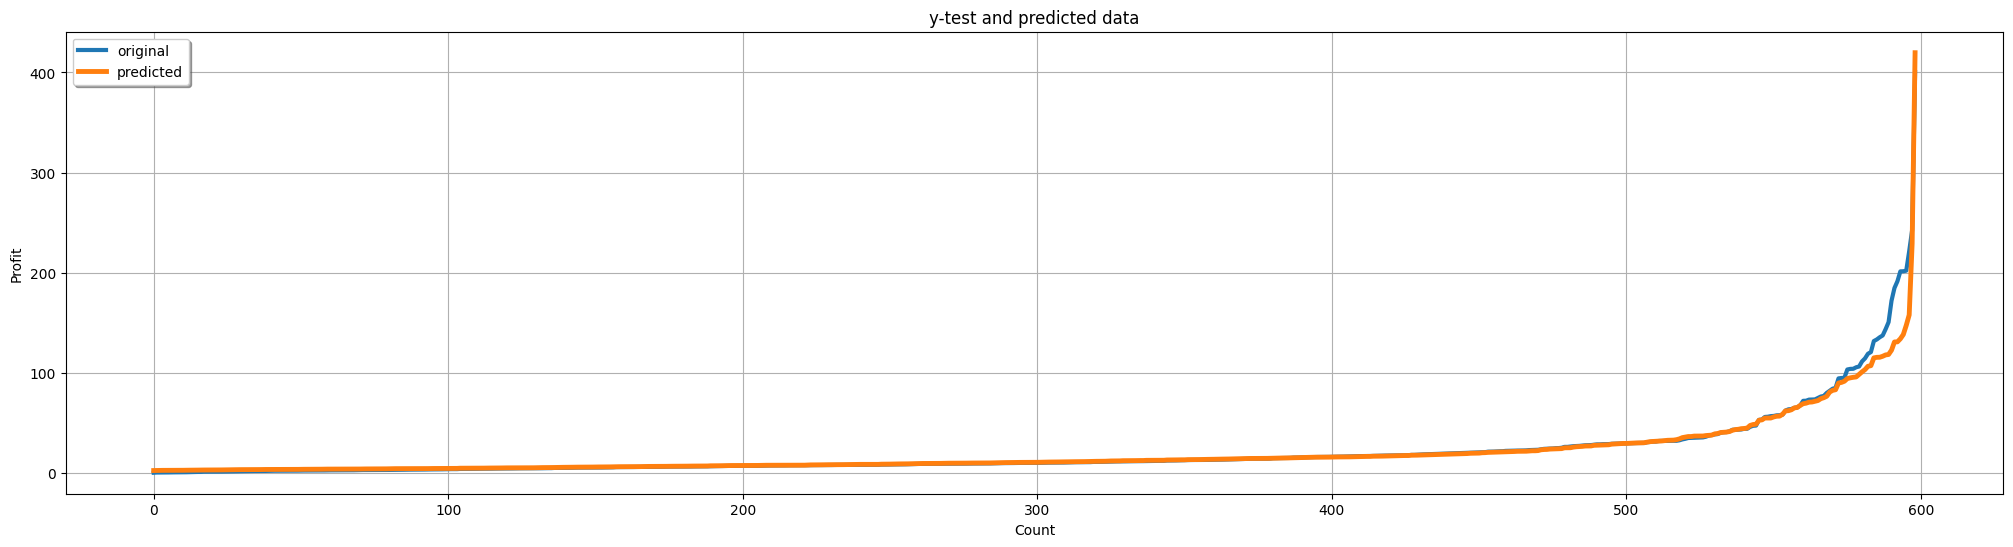

In [86]:
# Trực quan hoá so sánh kết quả trên tập test và kết quả dự đoán
x_ax = range(len(Y_test_origin))
plt.figure(figsize=(25,6))
plt.plot(x_ax, Y_test_origin, linewidth=3, label="original")
plt.plot(x_ax, prediction_result, linewidth=3.5, label="predicted")
plt.title("y-test and predicted data")
plt.xlabel('Count')
plt.ylabel('Market Value')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Xây dựng thuật toán Linear Regression (Hướng làm 2)

In [87]:
# tạo 2 tập Train và Test bằng zip => mỗi dòng sẽ là 1 cặp key-value
rdd_train = rdd_X_train_1.zip(rdd_Y_train_1)
rdd_test = rdd_X_test_1.zip(rdd_Y_test_1)

In [89]:
rdd_train.count()

1325

In [90]:
rdd_test.count()

599

In [91]:
# Tính toán giá trị trung bình của mảng
# Đầu vào sẽ là 1 tuple (key-value)
def estimate_coef(data):
  # Số lượng phần tử trong m
  n = data.count()

  # Trung bình của mảng bao gồm các keys
  sum_x = data.keys().reduce(lambda a, b: a + b)
  mean_x = sum_x/n
  # Trung bình của mảng bao gồm các values
  sum_y = data.values().reduce(lambda a, b: a + b)
  mean_y = sum_y/n
  # Tính toán giá trị cross-deviation (độ lệch chéo) và deviation của x và y
  sum_xy = data.map(lambda x: (x[0],x[0]*x[1])).values().reduce(lambda x,y: x+y)
  SS_xy = sum_xy - n*mean_x*mean_y

  sum_xx = data.map(lambda x: (x[0],x[0]*x[0])).values().reduce(lambda x,y: x+y)
  SS_xx = sum_xx - n*mean_x*mean_x

  # Tính toán hệ số hồi quy
  b_1 = SS_xy / SS_xx
  b_0 = mean_y - b_1*mean_x

  return (b_0, b_1)

In [92]:
# Hệ số ước lượng (estimating coefficients)
b = estimate_coef(rdd_train)
print("Hệ số ước lượng:\nb_0 = {} \nb_1 = {}".format(b[0],b[1]))

Hệ số ước lượng:
b_0 = 2.1053582923410943 
b_1 = 0.8938020501607846


In [98]:
# Hàm dự đoán - trả về các giá trị y
def simple_linear_regression(train,test):
  b_0, b_1 = estimate_coef(train)
  predictions = test.keys().map(lambda x: x*b_1 + b_0)
  return predictions

In [101]:
# Ứng dụng mô hình dự đoán trên tập Test
start = time.time()
prediction = simple_linear_regression(rdd_train, rdd_test)
end = time.time()
run_time_method_2 = end - start
print(">>>> Run Time : "+ str(run_time_method_2) + "(s)")

>>>> Run Time : 3.2412633895874023(s)


In [102]:
# Hàm tính RMSE
def rmse_metric(actual, predict):
  rdd_zip = actual.zip(predict)

  predict_error = rdd_zip.map(lambda a: a[0] - a[1])
  predict_error_square = predict_error.map(lambda a: a**2)

  sum_error = predict_error_square.reduce(lambda a,b: a+b)
  # print(sum_error)
  mean_error = sum_error/float(actual.count())
  rmse = math.sqrt(mean_error)
  return rmse

In [103]:
# Hàm đánh giá thuật toán hồi quy trên tập dữ liệu huấn luyện
def evaluate_algorithm(train,test):
  Y_test = test.values()
  Y_predict = simple_linear_regression(train,test)
  rmse = rmse_metric(Y_test, Y_predict)
  return rmse

In [104]:
# Đánh giá thuật toán hồi quy trên tập dữ liệu huấn luyện
import math
evaluate_model_HL2 = evaluate_algorithm(rdd_train, rdd_test)
print("Chỉ số RMSE: {} ".format(evaluate_model_HL2))

Chỉ số RMSE: 7.039201229422472 


In [106]:
# Trực quan hoá và so sánh kết quả dự đoán và thực tế
# Lấy giá trị gốc và dự đoán
y_test=rdd_test.values().collect()
y_predict = simple_linear_regression(rdd_train, rdd_test).collect()

In [107]:
# So sánh giá trị Market dự đoán và giá trị gốc
compare = DataFrame({'Origin': y_test, 'Predict': y_predict})
compare.head(10)

,Origin,Predict
0,0.2,2.373499
1,0.4,2.462879
2,0.4,2.552259
3,0.4,2.552259
4,0.5,2.552259
5,0.5,2.552259
6,0.6,2.641640
7,0.6,2.641640
8,0.6,2.641640
9,0.7,2.641640


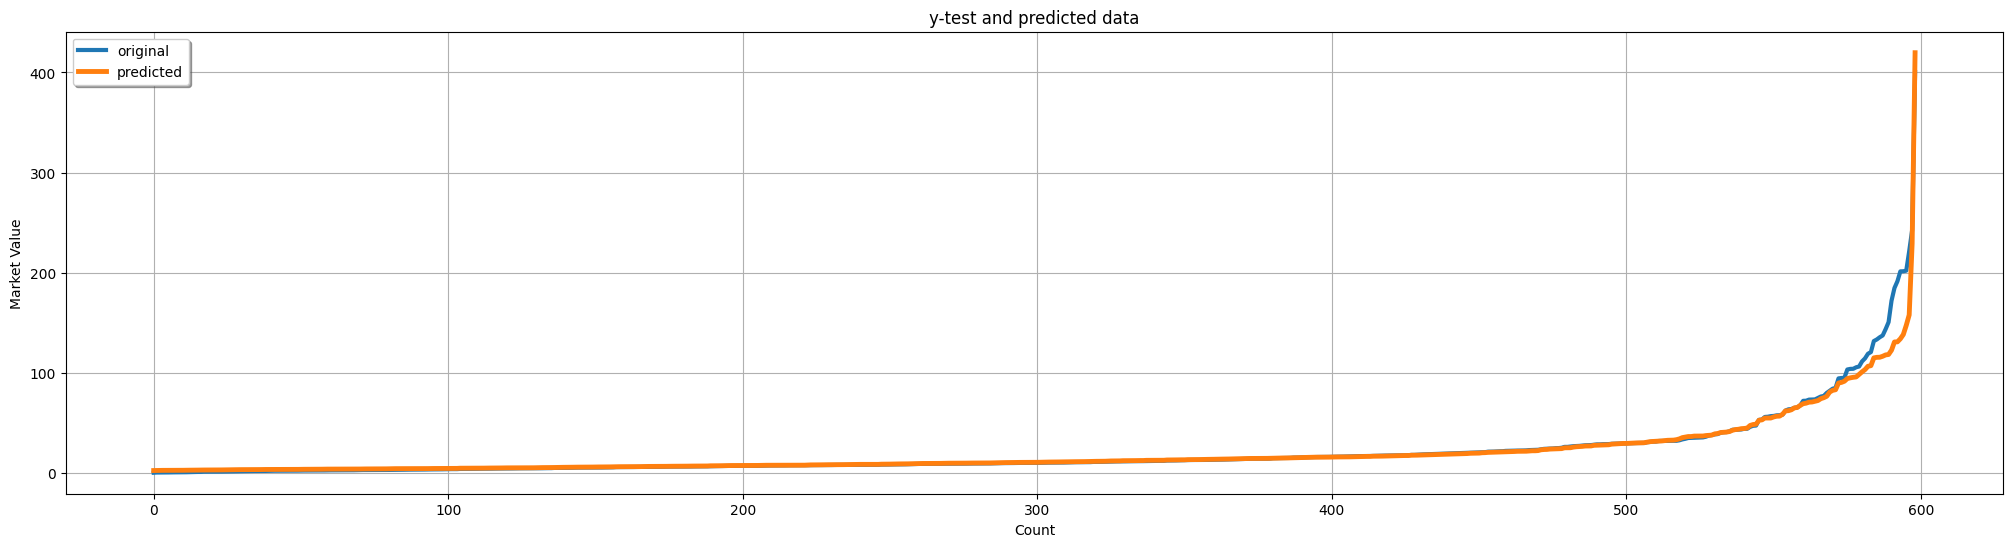

In [108]:
# Trực quan hoá so sánh kết quả trên tập test và kết quả dự đoán
x_ax =  range(len(y_test))
plt.figure(figsize=(25,6))
plt.plot(x_ax, y_test, linewidth=3, label="original")
plt.plot(x_ax, y_predict, linewidth=3.5, label="predicted")
plt.title("y-test and predicted data")
plt.xlabel('Count')
plt.ylabel('Market Value')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()